<a href="https://colab.research.google.com/github/maryblue31/JavaBlue/blob/master/Text%20Classification%20with%20Linear%20Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

!rm -rf /content/aclImdb/train/unsup
!rm -rf /content/aclImdb/train/labeledBow.feat
!rm -rf /content/aclImdb/train/unsupBow.feat
!rm -rf /content/aclImdb/train/urls_neg.txt
!rm -rf /content/aclImdb/train/urls_pos.txt
!rm -rf /content/aclImdb/train/urls_unsup.txt

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/uns

In [2]:
from sklearn.datasets import load_files  
movies = load_files(container_path="/content/aclImdb/train", encoding="utf-8")  
x, y = movies.data, movies.target 

import numpy as np

import nltk
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
docs = []
sequences = []

for doc in x: 
    
    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
      
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [stemmer.lemmatize(word) for word in document]
    sequences.append(document)
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from sklearn.model_selection import train_test_split  

x_train, x_dev_test, y_train, y_dev_test = train_test_split(docs, y, test_size=0.4, random_state=23828748)
x_test, x_dev, y_test, y_dev = train_test_split(x_dev_test, y_dev_test, test_size=0.5, random_state=23828748)

#docs statistics
train_length = len(x_train)
dev_length = len(x_dev)
test_length = len(x_test)

sum_words = 0 
for sequence in sequences:
  sum_words = sum_words+len(sequence)

average_words = sum_words/len(sequences)

print('Length of train dataset: '+str(train_length))
print('Length of development dataset: '+str(dev_length))
print('Length of test dataset: '+str(test_length))

print('Average words per document: '+str(average_words))

Length of train dataset: 15000
Length of development dataset: 5000
Length of test dataset: 5000
Average words per document: 228.45852


In [4]:
vocabulary = dict()
for sequence in sequences:
  for word in sequence:
    if(word not in vocabulary):
      vocabulary[word]= 1
    else:
      vocabulary[word] = vocabulary[word]+1

print('Length of vocabulary: '+str(len(vocabulary)))

Length of vocabulary: 67244


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Exclude stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 10000,
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train) #Tf-idf-weighted Xsparse matrix of (n_samples, n_features)
x_test_tfidf = vectorizer.transform(x_test)  #tf-idf-weighted Xsparse matrix for test
x_dev_tfidf = vectorizer.transform(x_dev)

In [7]:
#feature selection



from sklearn.feature_selection import mutual_info_classif

k=5000 #find the k best features 
x_train_tfidf_array = x_train_tfidf.toarray() # convert Xsparse matrix to a dense matrix
x_dev_tfidf_array = x_dev_tfidf.toarray()

#1dim matrix with the features and their mutual regression score(IG), length=5000
features = mutual_info_classif(x_train_tfidf_array, y_train, n_neighbors=3, discrete_features=True, random_state=4342)

indexes = np.arange(len(features)) # to assing an index to each feature

sorted_features = sorted(zip(features, indexes), reverse=True) #sort the tuples (value, index) by the best (max) values

best_ind = [ind for val, ind in sorted_features[:k]] # take the idx for the k max tf-idf values of the features 


x_train_best_tfidf  = x_train_tfidf_array[:, best_ind] # take a dense matrix of k best features for train
x_test_best_tfidf = x_test_tfidf[:, best_ind] # take a Xsparse matrix of k best features for test
x_dev_best_tfidf = x_dev_tfidf_array[:, best_ind]  # take a Xsparse matrix of k best features for dev


x_train_tfidf = x_train_best_tfidf 
x_test_tfidf = x_test_best_tfidf
x_dev_tfidf = x_dev_best_tfidf



Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warni

In [8]:

#Precision-Recall
# class 1 is positive
def prec_rec_f1(y_train,predictions,c=1):  # returns matrix(2,3) where the 1st row prf1 of given class, the 2nd row macro-rpf1 
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    for i in range(len(y_train)):
        if y_train[i]==1 and predictions[i]==1 :
            TP +=1
        elif y_train[i]==0 and predictions[i]==1 :
            FP +=1
        elif y_train[i]==1 and predictions[i]==0 :
            FN +=1
        elif y_train[i]==0 and predictions[i]==0 :
            TN +=1


    if FP ==0:
        precision_positive =1
    else:   
        precision_positive = TP/(TP+FP)
    if FN == 0:
      recall_positive = 1 
    else : 
      recall_positive = TP/(TP+FN)
    f1_positive = (2*precision_positive*recall_positive)/(precision_positive + recall_positive)
    


    if FN == 0:
        precision_negative = 1
    else:
        precision_negative = TN/(TN+FN)
    if FP == 0:
      recall_negative = 1
    else:
      recall_negative = TN/(TN+FP)
    f1_negative = (2*precision_negative*recall_negative)/(precision_negative + recall_negative)

    macro_precision = (precision_negative+precision_positive)/2
    macro_recall = (recall_negative+recall_positive)/2
    macrof1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)

    


    if c == 1: 
        return [[precision_positive, recall_positive, f1_positive] , [macro_precision, macro_recall, macrof1]]

    elif c == 0: 
        return [[precision_negative, recall_negative, f1_negative] , [macro_precision, macro_recall, macrof1]]
    

In [9]:
import matplotlib.pyplot as plt
from sklearn import metrics    
    
def precision_recall_curve(prob_pred, actual_values, clf,  color = 'red', c=1):
    pre = []
    rec = []
    prediction = [0]*len(prob_pred)
    

    for t in range(0,100):
        for i in range(len(prob_pred)):
            if prob_pred[i]>t/100.0: 
                prediction[i] = c
            else: 
                prediction[i] = 1-c




In [31]:
import matplotlib.pyplot as plt
from sklearn import metrics    
    
def precision_recall_curve(prob_pred, actual_values, clf,  color = 'red', c=1):
    pre = []
    rec = []
    prediction = [0]*len(prob_pred)
    

    for t in range(0,100):
        for i in range(len(prob_pred)):
            if prob_pred[i]>t/100.0: 
                prediction[i] = c
            else: 
                prediction[i] = 1-c



        
        Precision_recall_F1 = prec_rec_f1(actual_values, prediction,c)

        # για να παρω plot με precision-recall της κατηγοριας που εξεταζω
        pre.append(Precision_recall_F1[0][0])
        rec.append(Precision_recall_F1[0][1])



    if c == 0:
      color = 'blue'

    auc = -np.trapz(pre, x=rec)
    
    #create precision recall curve
    plt.plot(rec, pre, label = "AUC = %0.5f" % auc,  color = color)
    plt.legend()

    #add axis labels to plot
    plt.title('Precision-Recall Curve of ' + clf)
    plt.ylim([0.0, 1.1])
    plt.xlim([0.0, 1.0])
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    #display plot
    plt.show()    

    return auc
    

    
    

In [32]:
#learning curves
def learning_curves(clf, title, ylim):
    rows=0
    clf = clf
 
    x = []
    y = []
    y1 = []
    y2 = []
    x_train_dataset = x_train_tfidf
    step = int(len(x_train_dataset)/5)

    for i in range(5):
        rows = rows+step
        x.append(rows)
        x_train_data = x_train_dataset[0: rows, :]
        y_train_data = y_train[0: rows]
    
        clf.fit(x_train_data, y_train_data)
        predictions = clf.predict(x_train_data)
        f1_macro = prec_rec_f1(y_train_data,predictions)
       
        f1_macro_score =f1_macro[1][2]
        y.append(f1_macro_score)

        test_predictions = clf.predict(x_test_tfidf)
        f1_macro_test = prec_rec_f1(y_test,test_predictions)
        f1_macro_score_test =f1_macro_test[1][2]
        y1.append(f1_macro_score_test)  

        dev_predictions = clf.predict(x_dev_tfidf)
        f1_macro_dev = prec_rec_f1(y_dev,dev_predictions)
        f1_macro_score_dev =f1_macro_dev[1][2]
        y2.append(f1_macro_score_dev)

    plt.figure()
    plt.title(title)
    plt.grid()
    plt.xlabel('Training examples')
    plt.ylabel('MacroF1 score')
    plt.plot(x, y, 'o-', color="b",
             label="Training score")
    plt.plot(x, y1, 'o-', color="orange",
             label="Test score")
    plt.plot(x, y2, 'o-', color="green",
             label="Dev score")
    plt.legend(loc="lower right")
    plt.ylim(ylim)
    return plt


In [33]:
#Baseline Classifier


from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import pandas as pd
import time



# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training of Baseline took: {} seconds \n".format(time.time() - start_time))


print ('FOR BASELINE:\n')

# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(y_test, predictions_dev)
print("Dev accuracy: {:.2f}%".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))



print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset: ', np.where(y_train == 1)[0].shape, '\n')

Training of Baseline took: 0.0013511180877685547 seconds 

FOR BASELINE:

Train accuracy: 50.15%
Dev accuracy: 50.52%
Test accuracy: 50.52% 

#Class 0 in Train dataset: (7522,)
#Class 1 in Train dataset:  (7478,) 



In [34]:
score_train1 = baseline.predict_proba(x_train_tfidf)[:,1] # αυτό εδώ δίνει μια πιθανότητα σε κάθε text_of_train να ανήκει στη θετική κατηγορία - την υπολογίζει μέσω των tf-idf
score_test1 = baseline.predict_proba(x_test_tfidf)[:,1]
score_dev1 = baseline.predict_proba(x_dev_tfidf)[:,1]

score_train0 = baseline.predict_proba(x_train_tfidf)[:,0] # δινει πιθανοτητα για καθε text_of_train να ανηκει στην αρνητικη
score_test0 = baseline.predict_proba(x_test_tfidf)[:,0]
score_dev0 = baseline.predict_proba(x_dev_tfidf)[:,0]



prftrain1 = prec_rec_f1(y_train,predictions,c=1)[0]
prftest1 = prec_rec_f1(y_test,predictions_test,c=1)[0]
prfdev1 = prec_rec_f1(y_dev,predictions_dev,c=1)[0]

prftrain0 = prec_rec_f1(y_train,predictions,c=0)[0]
prftest0 = prec_rec_f1(y_test,predictions_test,c=0)[0]
prfdev0 = prec_rec_f1(y_dev,predictions_dev,c=0)[0]

prfmacrotrain = prec_rec_f1(y_train,predictions,c=1)[1]
prfmacrodev = prec_rec_f1(y_dev,predictions_dev,c=1)[1]
prfmacrotest = prec_rec_f1(y_test, predictions_test,c=1)[1]

For class 1:



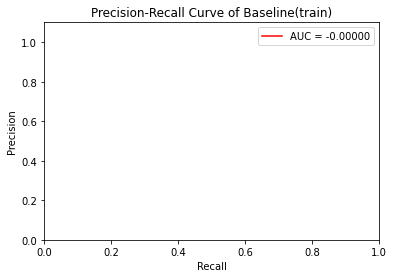

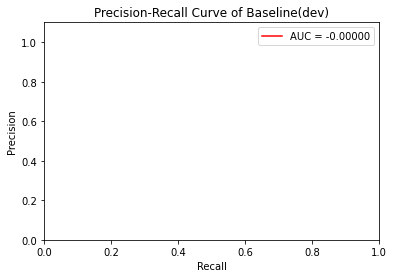

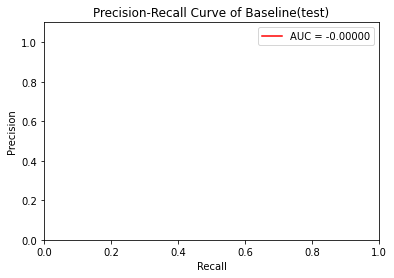

Precision of train = 1
Recall of train = 0.0
Fi-score of train = 0.0

Precision of develop = 1
Recall of develop = 0.0
Fi-score of develop = 0.0

Precision of test = 1
Recall of test = 0.0
Fi-score of test = 0.0

Auc for train (class 1) in Baseline is -0.0
Auc for dev (class 1) in Baseline is -0.0
Auc for test (class 1) in Baseline is -0.0

For class 0:



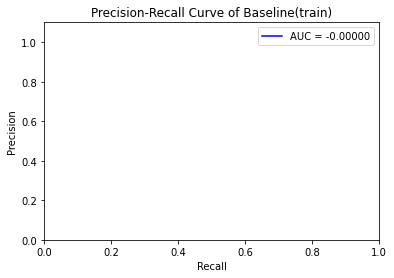

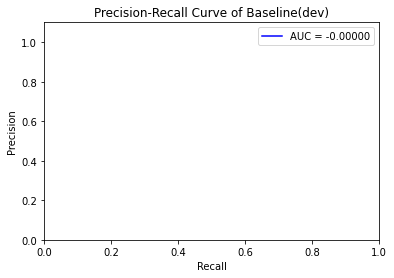

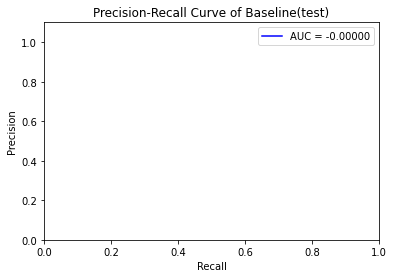

Precision of train = 0.5014666666666666
Recall of train = 1
Fi-score of train = 0.6679690968830477

Precision of develop = 0.4904
Recall of develop = 1
Fi-score of develop = 0.6580783682232958

Precision of test = 0.5052
Recall of test = 1
Fi-score of test = 0.6712729205421207

Auc for train (class 0) in Baseline is -0.0
Auc for dev (class 0) in Baseline is -0.0
Auc for test (class 0) in Baseline is -0.0



In [35]:
# για θετικη κατηγορια
print ('For class 1:\n')
auc_train1 = precision_recall_curve(score_train1, y_train, 'Baseline(train)' )
auc_dev1 = precision_recall_curve(score_dev1, y_dev, 'Baseline(dev)')
auc_test1 = precision_recall_curve(score_test1, y_test, 'Baseline(test)')


print ('Precision of train = ' + str(prftrain1[0]) +'\n' + 'Recall of train = '+ str(prftrain1[1]) + '\n' + 'Fi-score of train = ' + str(prftrain1[2])+'\n')
print ('Precision of develop = ' + str(prfdev1[0]) +'\n' + 'Recall of develop = '+ str(prfdev1[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev1[2])+'\n')
print ('Precision of test = ' + str(prftest1[0]) +'\n' + 'Recall of test = '+ str(prftest1[1]) + '\n' + 'Fi-score of test = ' + str(prftest1[2])+'\n')

print ('Auc for train (class 1) in Baseline is ' + str(auc_train1))
print ('Auc for dev (class 1) in Baseline is ' + str(auc_dev1))
print ('Auc for test (class 1) in Baseline is ' + str(auc_test1)+'\n')

# για αρνητικη κατηγορια
print ('For class 0:\n')
auc_train0=precision_recall_curve(score_train0,  y_train,'Baseline(train)', c=0)
auc_dev0=precision_recall_curve(score_dev0, y_dev, 'Baseline(dev)', c=0)
auc_test0=precision_recall_curve(score_test0, y_test, 'Baseline(test)', c=0)



print ('Precision of train = ' + str(prftrain0[0]) +'\n' + 'Recall of train = '+ str(prftrain0[1]) + '\n' + 'Fi-score of train = ' + str(prftrain0[2])+'\n')
print ('Precision of develop = ' + str(prfdev0[0]) +'\n' + 'Recall of develop = '+ str(prfdev0[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev0[2])+'\n')
print ('Precision of test = ' + str(prftest0[0]) +'\n' + 'Recall of test = '+ str(prftest0[1]) + '\n' + 'Fi-score of test = ' + str(prftest0[2])+'\n')


print ('Auc for train (class 0) in Baseline is ' + str(auc_train0))
print ('Auc for dev (class 0) in Baseline is ' + str(auc_dev0))
print ('Auc for test (class 0) in Baseline is ' + str(auc_test0)+'\n')

In [36]:
#Macro
print ( 'MacroPrecision for train = ' + str(prfmacrotrain[0]) + '\n' + 'MacroRecall for train = ' + str(prfmacrotrain[1]) + '\n' + 'MacroF1-score for train = ' + str(prfmacrotrain[2])+'\n')
print ( 'MacroPrecision for dev = ' + str(prfmacrodev[0]) + '\n' + 'MacroRecall for dev = ' + str(prfmacrodev[1]) + '\n' + 'MacroF1-score for dev = ' + str(prfmacrodev[2])+'\n')
print ( 'MacroPrecision for test = ' + str(prfmacrotest[0]) + '\n' + 'MacroRecall for test = ' + str(prfmacrotest[1]) + '\n' + 'MacroF1-score for test = ' + str(prfmacrotest[2])+'\n')

macro_auc_train = (auc_train1+auc_train0)/2
macro_auc_test = (auc_test1+auc_test0)/2
macro_auc_dev = (auc_dev1+auc_dev0)/2


print ('Macro auc for train is ' + str(macro_auc_train))
print ('Macro auc for dev is ' + str(macro_auc_dev))
print ('Macro auc for test is ' + str(macro_auc_test)+'\n')

MacroPrecision for train = 0.7507333333333333
MacroRecall for train = 0.5
MacroF1-score for train = 0.6002345290762753

MacroPrecision for dev = 0.7452
MacroRecall for dev = 0.5
MacroF1-score for dev = 0.5984580790234499

MacroPrecision for test = 0.7525999999999999
MacroRecall for test = 0.5
MacroF1-score for test = 0.6008302730320932

Macro auc for train is -0.0
Macro auc for dev is -0.0
Macro auc for test is -0.0



In [37]:
#Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix



clf = LogisticRegression(solver="liblinear", C=1.0, max_iter = 50)
start_time = time.time()
clf.fit(x_train_tfidf, y_train)

print("Training of Logistic Regression took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = clf.predict(x_train_tfidf) # np.ndarray with predictions about the class of each text in train data

predictions_dev = clf.predict(x_dev_tfidf) # np.ndarray with predictions about the class of each text in test data

predictions_test = clf.predict(x_test_tfidf) # np.ndarray with predictions about the class of each text in test data


Training of Logistic Regression took: 1.0195987224578857 seconds 



FOR LOGISTIC REGRESSION:

For class 1:



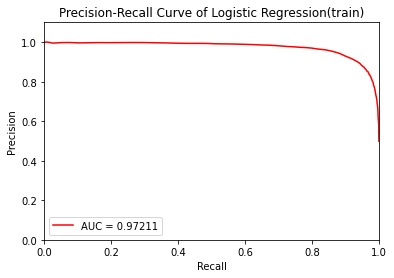

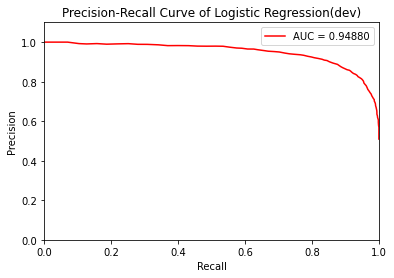

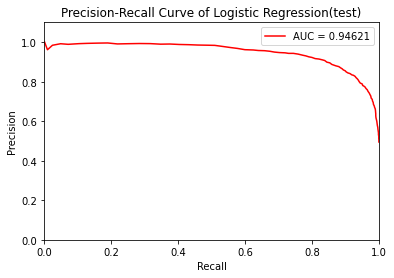

Precision of train = 0.9070374722548635
Recall of train = 0.9289917090131051
Fi-score of train = 0.9178833322322786

Precision of develop = 0.8705476828801225
Recall of develop = 0.8920722135007849
Fi-score of develop = 0.8811785229695677

Precision of test = 0.859642301710731
Recall of test = 0.8936944219886823
Fi-score of test = 0.8763376932223543

Auc for train (class 1) in Logistic Regression is 0.9721100984294303
Auc for dev (class 1) in Logistic Regression is 0.9487973890333519
Auc for test (class 1) in Logistic Regression is 0.9462065110343049

For class 0:



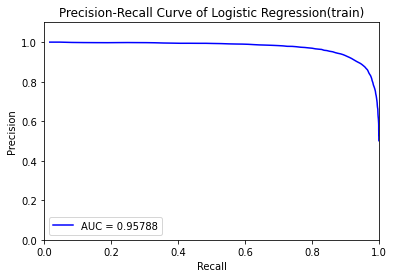

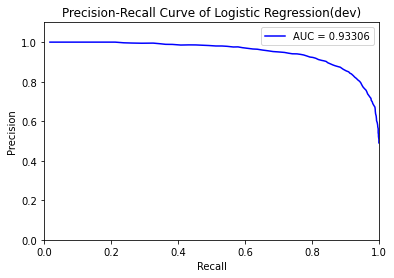

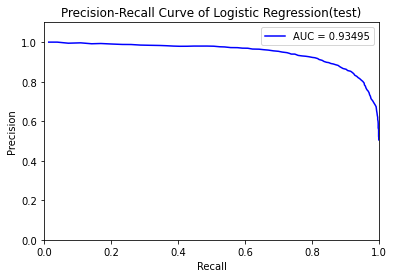

Precision of train = 0.9276665304454434
Recall of train = 0.9053443233182664
Fi-score of train = 0.916369508174662

Precision of develop = 0.8848890749267476
Recall of develop = 0.8621533442088092
Fi-score of develop = 0.8733732699855402

Precision of test = 0.8916803953871499
Recall of test = 0.8570863024544735
Fi-score of test = 0.8740411788453775

Auc for train (class 0) in in Logistic Regression is 0.9578818571844194
Auc for dev (class 0) in in Logistic Regression is 0.9330631190009777
Auc for test (class 0) in in Logistic Regression is 0.9349523650886887



In [38]:
score_train1 = clf.predict_proba(x_train_tfidf)[:,1] # αυτό εδώ δίνει μια πιθανότητα σε κάθε text_of_train να ανήκει στη θετική κατηγορία - την υπολογίζει μέσω των tf-idf
score_test1 = clf.predict_proba(x_test_tfidf)[:,1]
score_dev1 = clf.predict_proba(x_dev_tfidf)[:,1]

score_train0 = clf.predict_proba(x_train_tfidf)[:,0] # δινει πιθανοτητα για καθε text_of_train να ανηκει στην αρνητικη
score_test0 = clf.predict_proba(x_test_tfidf)[:,0]
score_dev0 = clf.predict_proba(x_dev_tfidf)[:,0]




prftrain1 = prec_rec_f1(y_train,predictions,c=1)[0]
prftest1 = prec_rec_f1(y_test,predictions_test,c=1)[0]
prfdev1 = prec_rec_f1(y_dev,predictions_dev,c=1)[0]

prftrain0 = prec_rec_f1(y_train,predictions,c=0)[0]
prftest0 = prec_rec_f1(y_test,predictions_test,c=0)[0]
prfdev0 = prec_rec_f1(y_dev,predictions_dev,c=0)[0]

prfmacrotrain = prec_rec_f1(y_train,predictions,c=1)[1]
prfmacrodev = prec_rec_f1(y_dev,predictions_dev,c=1)[1]
prfmacrotest = prec_rec_f1(y_test, predictions_test,c=1)[1]





print ('FOR LOGISTIC REGRESSION:\n')

# για θετικη κατηγορια
print ('For class 1:\n')
auc_train1 = precision_recall_curve(score_train1, y_train, 'Logistic Regression(train)')
auc_dev1 = precision_recall_curve(score_dev1, y_dev, 'Logistic Regression(dev)')
auc_test1 = precision_recall_curve(score_test1, y_test, 'Logistic Regression(test)')


print ('Precision of train = ' + str(prftrain1[0]) +'\n' + 'Recall of train = '+ str(prftrain1[1]) + '\n' + 'Fi-score of train = ' + str(prftrain1[2])+'\n')
print ('Precision of develop = ' + str(prfdev1[0]) +'\n' + 'Recall of develop = '+ str(prfdev1[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev1[2])+'\n')
print ('Precision of test = ' + str(prftest1[0]) +'\n' + 'Recall of test = '+ str(prftest1[1]) + '\n' + 'Fi-score of test = ' + str(prftest1[2])+'\n')

print ('Auc for train (class 1) in Logistic Regression is ' + str(auc_train1))
print ('Auc for dev (class 1) in Logistic Regression is ' + str(auc_dev1))
print ('Auc for test (class 1) in Logistic Regression is ' + str(auc_test1)+'\n')



# για αρνητικη κατηγορια
print ('For class 0:\n')
auc_train0 = precision_recall_curve(score_train0, y_train,'Logistic Regression(train)', c=0)
auc_dev0 = precision_recall_curve(score_dev0, y_dev, 'Logistic Regression(dev)', c=0)
auc_test0 = precision_recall_curve(score_test0, y_test, 'Logistic Regression(test)', c=0)



print ('Precision of train = ' + str(prftrain0[0]) +'\n' + 'Recall of train = '+ str(prftrain0[1]) + '\n' + 'Fi-score of train = ' + str(prftrain0[2])+'\n')
print ('Precision of develop = ' + str(prfdev0[0]) +'\n' + 'Recall of develop = '+ str(prfdev0[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev0[2])+'\n')
print ('Precision of test = ' + str(prftest0[0]) +'\n' + 'Recall of test = '+ str(prftest0[1]) + '\n' + 'Fi-score of test = ' + str(prftest0[2])+'\n')

print ('Auc for train (class 0) in in Logistic Regression is ' + str(auc_train0))
print ('Auc for dev (class 0) in in Logistic Regression is ' + str(auc_dev0))
print ('Auc for test (class 0) in in Logistic Regression is ' + str(auc_test0)+'\n')

In [39]:
#Macro
print ( 'MacroPrecision for train = ' + str(prfmacrotrain[0]) + '\n' + 'MacroRecall for train = ' + str(prfmacrotrain[1]) + '\n' + 'MacroF1-score for train = ' + str(prfmacrotrain[2])+'\n')
print ( 'MacroPrecision for dev = ' + str(prfmacrodev[0]) + '\n' + 'MacroRecall for dev = ' + str(prfmacrodev[1]) + '\n' + 'MacroF1-score for dev = ' + str(prfmacrodev[2])+'\n')
print ( 'MacroPrecision for test = ' + str(prfmacrotest[0]) + '\n' + 'MacroRecall for test = ' + str(prfmacrotest[1]) + '\n' + 'MacroF1-score for test = ' + str(prfmacrotest[2])+'\n')

macro_auc_train = (auc_train1+auc_train0)/2
macro_auc_test = (auc_test1+auc_test0)/2
macro_auc_dev = (auc_dev1+auc_dev0)/2


print ('Macro auc for train is ' + str(macro_auc_train))
print ('Macro auc for dev is ' + str(macro_auc_dev))
print ('Macro auc for test is ' + str(macro_auc_test)+'\n')

MacroPrecision for train = 0.9173520013501535
MacroRecall for train = 0.9171680161656858
MacroF1-score for train = 0.9172599995319237

MacroPrecision for dev = 0.8777183789034351
MacroRecall for dev = 0.877112778854797
MacroF1-score for dev = 0.877415474381479

MacroPrecision for test = 0.8756613485489404
MacroRecall for test = 0.875390362221578
MacroF1-score for test = 0.8755258344168351

Macro auc for train is 0.9649959778069248
Macro auc for dev is 0.9409302540171648
Macro auc for test is 0.9405794380614968



In [40]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

# Train
clfnb = MultinomialNB(alpha=0.03)
start_time = time.time()
clfnb.fit(x_train_tfidf, y_train)
print("Training of Naive Bayes took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = clfnb.predict(x_train_tfidf)

predictions_test = clfnb.predict(x_test_tfidf)

predictions_dev = clfnb.predict(x_dev_tfidf)




score_train1 = clfnb.predict_proba(x_train_tfidf)[:,1] # αυτό εδώ δίνει μια πιθανότητα σε κάθε text_of_train να ανήκει στη θετική κατηγορία - την υπολογίζει μέσω των tf-idf
score_test1 = clfnb.predict_proba(x_test_tfidf)[:,1]
score_dev1 = clfnb.predict_proba(x_dev_tfidf)[:,1]

score_train0 = clfnb.predict_proba(x_train_tfidf)[:,0] # δινει πιθανοτητα για καθε text_of_train να ανηκει στην αρνητικη
score_test0 = clfnb.predict_proba(x_test_tfidf)[:,0]
score_dev0 = clfnb.predict_proba(x_dev_tfidf)[:,0]

Training of Naive Bayes took: 0.27190685272216797 seconds 



FOR NAIVE BAYES:

For class 1:



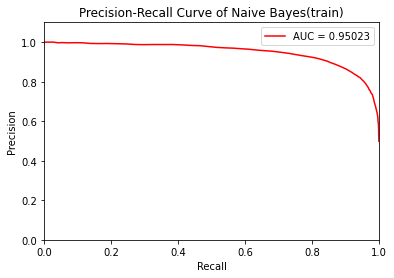

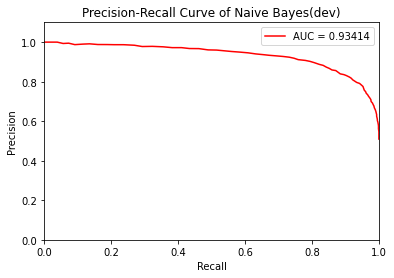

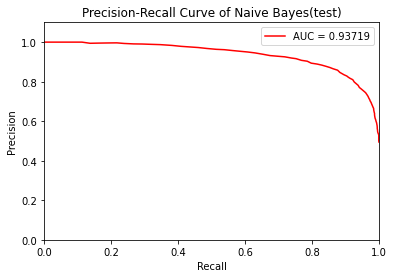

Precision of train = 0.8693506493506493
Recall of train = 0.8951591334581439
Fi-score of train = 0.8820661483726446

Precision of develop = 0.8474062854979174
Recall of develop = 0.8783359497645212
Fi-score of develop = 0.8625939487377143

Precision of test = 0.8413001912045889
Recall of test = 0.889248181083266
Fi-score of test = 0.8646099430143446

Auc for train (class 1) in Naive Bayes is 0.9502346027546248
Auc for dev (class 1) in Naive Bayes is 0.934140761317186
Auc for test (class 1) in Naive Bayes is 0.9371912222399157

For class 0:



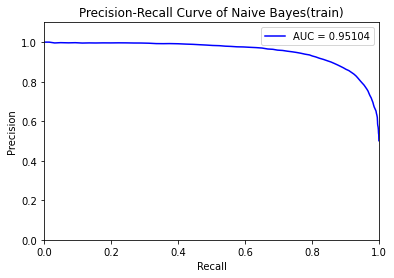

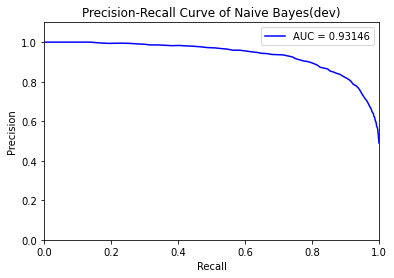

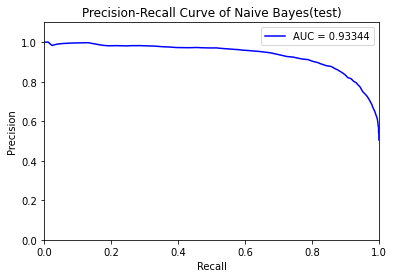

Precision of train = 0.8926027397260274
Recall of train = 0.8662589736772135
Fi-score of train = 0.8792335717177169

Precision of develop = 0.8685883849088597
Recall of develop = 0.8356443719412724
Fi-score of develop = 0.8517979630014549

Precision of test = 0.8851153039832285
Recall of test = 0.8357086302454474
Fi-score of test = 0.859702708206068

Auc for train (class 0) in Naive Bayes is 0.9510369464709089
Auc for dev (class 0) in Naive Bayes is 0.931458818656563
Auc for test (class 0) in Naive Bayes is 0.9334422045841976



In [41]:
prftrain1 = prec_rec_f1(y_train,predictions,c=1)[0]
prftest1 = prec_rec_f1(y_test,predictions_test,c=1)[0]
prfdev1 = prec_rec_f1(y_dev,predictions_dev,c=1)[0]

prftrain0 = prec_rec_f1(y_train,predictions,c=0)[0]
prftest0 = prec_rec_f1(y_test,predictions_test,c=0)[0]
prfdev0 = prec_rec_f1(y_dev,predictions_dev,c=0)[0]

prfmacrotrain = prec_rec_f1(y_train,predictions,c=1)[1]
prfmacrodev = prec_rec_f1(y_dev,predictions_dev,c=1)[1]
prfmacrotest = prec_rec_f1(y_test, predictions_test,c=1)[1]





print ('FOR NAIVE BAYES:\n')

# για θετικη κατηγορια
print ('For class 1:\n')
auc_train1 = precision_recall_curve(score_train1, y_train, 'Naive Bayes(train)' )
auc_dev1 = precision_recall_curve(score_dev1, y_dev, 'Naive Bayes(dev)')
auc_test1 = precision_recall_curve(score_test1, y_test, 'Naive Bayes(test)')


print ('Precision of train = ' + str(prftrain1[0]) +'\n' + 'Recall of train = '+ str(prftrain1[1]) + '\n' + 'Fi-score of train = ' + str(prftrain1[2])+'\n')
print ('Precision of develop = ' + str(prfdev1[0]) +'\n' + 'Recall of develop = '+ str(prfdev1[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev1[2])+'\n')
print ('Precision of test = ' + str(prftest1[0]) +'\n' + 'Recall of test = '+ str(prftest1[1]) + '\n' + 'Fi-score of test = ' + str(prftest1[2])+'\n')


print ('Auc for train (class 1) in Naive Bayes is ' + str(auc_train1))
print ('Auc for dev (class 1) in Naive Bayes is ' + str(auc_dev1))
print ('Auc for test (class 1) in Naive Bayes is ' + str(auc_test1) + '\n')



# για αρνητικη κατηγορια
print ('For class 0:\n')
auc_train0 = precision_recall_curve(score_train0,  y_train,'Naive Bayes(train)', c=0)
auc_dev0 = precision_recall_curve(score_dev0, y_dev, 'Naive Bayes(dev)', c=0)
auc_test0 = precision_recall_curve(score_test0, y_test, 'Naive Bayes(test)', c=0)



print ('Precision of train = ' + str(prftrain0[0]) +'\n' + 'Recall of train = '+ str(prftrain0[1]) + '\n' + 'Fi-score of train = ' + str(prftrain0[2])+'\n')
print ('Precision of develop = ' + str(prfdev0[0]) +'\n' + 'Recall of develop = '+ str(prfdev0[1]) + '\n' + 'Fi-score of develop = ' + str(prfdev0[2])+'\n')
print ('Precision of test = ' + str(prftest0[0]) +'\n' + 'Recall of test = '+ str(prftest0[1]) + '\n' + 'Fi-score of test = ' + str(prftest0[2])+'\n')


print ('Auc for train (class 0) in Naive Bayes is ' + str(auc_train0))
print ('Auc for dev (class 0) in Naive Bayes is ' + str(auc_dev0))
print ('Auc for test (class 0) in Naive Bayes is ' + str(auc_test0)+'\n')

In [42]:
#Macro
print ( 'MacroPrecision for train = ' + str(prfmacrotrain[0]) + '\n' + 'MacroRecall for train = ' + str(prfmacrotrain[1]) + '\n' + 'MacroF1-score for train = ' + str(prfmacrotrain[2])+'\n')
print ( 'MacroPrecision for dev = ' + str(prfmacrodev[0]) + '\n' + 'MacroRecall for dev = ' + str(prfmacrodev[1]) + '\n' + 'MacroF1-score for dev = ' + str(prfmacrodev[2])+'\n')
print ( 'MacroPrecision for test = ' + str(prfmacrotest[0]) + '\n' + 'MacroRecall for test = ' + str(prfmacrotest[1]) + '\n' + 'MacroF1-score for test = ' + str(prfmacrotest[2])+'\n')

macro_auc_train = (auc_train1+auc_train0)/2
macro_auc_test = (auc_test1+auc_test0)/2
macro_auc_dev = (auc_dev1+auc_dev0)/2


print ('Macro auc for train is ' + str(macro_auc_train))
print ('Macro auc for dev is ' + str(macro_auc_dev))
print ('Macro auc for test is ' + str(macro_auc_test)+'\n')

MacroPrecision for train = 0.8809766945383384
MacroRecall for train = 0.8807090535676787
MacroF1-score for train = 0.8808428537225695

MacroPrecision for dev = 0.8579973352033885
MacroRecall for dev = 0.8569901608528968
MacroF1-score for dev = 0.8574934522824961

MacroPrecision for test = 0.8632077475939086
MacroRecall for test = 0.8624784056643566
MacroF1-score for test = 0.8628429225050327

Macro auc for train is 0.9506357746127668
Macro auc for dev is 0.9327997899868745
Macro auc for test is 0.9353167134120566



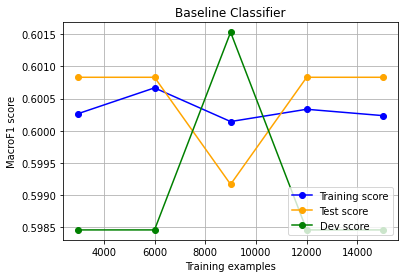

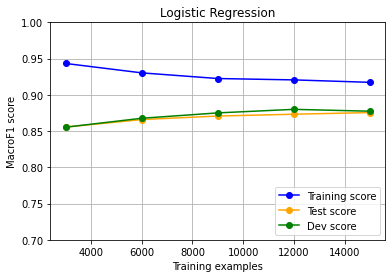

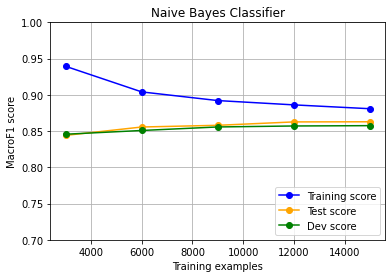

In [43]:

#Baseline Classifier learing curve
plt = learning_curves(baseline,  'Baseline Classifier', ylim=None)
plt.show()

#Linear Regression learing curves   
plt = learning_curves(clf,  'Logistic Regression', ylim=(0.7, 1))
plt.show()

#Naive Bayes Classifier learing curve
plt = learning_curves(clfnb, 'Naive Bayes Classifier',  ylim=(0.7, 1))
plt.show()


In [44]:
#tuning parameters

from sklearn.model_selection import GridSearchCV


# define grid search

print(x_train_tfidf.shape)
print(x_dev_tfidf.shape)

x1 = np.array(x_train_tfidf)
x2 = np.array(x_dev_tfidf)

X = np.concatenate((x1,x2), axis=0)
print(X.shape)
Y = np.concatenate((y_train,y_dev), axis=0)
print(Y.shape)

from sklearn.model_selection import PredefinedSplit

test_fold = []
for i in range(len(x_train_tfidf)):
    test_fold.append(-1)
for i in range(len(x_dev_tfidf)):
    test_fold.append(1)
  
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

custom_cv = ps.split()

model = LogisticRegression()
grid_params = {
  'solver': ['liblinear'],
  'penalty': ['l1','l2'],
  'C': np.linspace(0.1, 1, 10),
  'max_iter': [50, 100, 200]
}

gridLr = GridSearchCV(model, grid_params,scoring='f1',cv=custom_cv, n_jobs=-1)
start_time = time.time()
gridLr.fit(X, Y)
print("GridSearchCV for LR took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", gridLr.best_score_)
print("Best Params: ", gridLr.best_params_, '\n')

(15000, 5000)
(5000, 5000)
(20000, 5000)
(20000,)
GridSearchCV for LR took: 136.32367181777954 seconds 

Best Score:  0.8811785229695677
Best Params:  {'C': 1.0, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'} 



In [45]:
#naive Bayes

ps = PredefinedSplit(test_fold)
ps.get_n_splits()

custom_cv = ps.split()

model = MultinomialNB()
grid_params = {
  'alpha': np.linspace(0.01, 0.1, 10)
}

gridNb = GridSearchCV(model, grid_params,scoring='f1',cv=custom_cv, n_jobs=-1)
start_time = time.time()
gridNb.fit(X, Y)
print("GridSearchCV for NB took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", gridNb.best_score_)
print("Best Params: ", gridNb.best_params_)

GridSearchCV for NB took: 22.148364782333374 seconds 

Best Score:  0.8627602158828066
Best Params:  {'alpha': 0.1}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#for logistic regression

lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

grid_params = {
  'lr__solver': ['liblinear'],
  'lr__penalty': ['l1','l2'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
  'tfidf_vectorizer__min_df': np.linspace(0.01, 0.1, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False]
}

gridLr = GridSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3, n_jobs=-1)
start_time = time.time()
gridLr.fit(x_dev, y_dev)
print("GridSearchCV for LR took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", gridLr.best_score_)
print("Best Params:\n ", gridLr.best_params_)




#for Naive Bayes

nb_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())])

grid_params = {
  'nb__alpha': np.linspace(0.01, 0.1, 10),
  'tfidf_vectorizer__min_df': np.linspace(0.01, 0.1, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],
}

gridNb = GridSearchCV(nb_pipeline, grid_params,scoring='f1',cv=3, n_jobs=-1)
start_time = time.time()
gridNb.fit(x_dev, y_dev)
print("GridSearchCV for NB took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", gridNb.best_score_)
print("Best Params: ", gridNb.best_params_)